In [1]:
import pandas as pd
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

2022-08-03 15:06:42.983184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 15:06:42.983208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

ip = str(json.load(open('/home/onos/Downloads/flask_SDN/config.json'))['ip_local'])
file_name = str(ip).split('.')[-1] + '_lstm'
dataframe = pd.read_csv('/home/onos/Downloads/' + file_name + '.csv')


# Tiền Xử Lý

In [3]:
# dataframe.drop(['_id','byteSent','byteReceived','IpSDN','src', 'dst'], axis=1, inplace=True)
dataframe.drop(['IpSDN', 'src', 'dst'], axis=1, inplace=True)

# Xu ly mat can bang

In [4]:
# Separate majority and minority classes
df_minority = dataframe[dataframe['label'] ==1]
df_majority = dataframe[dataframe['label'] ==0]

print(len(df_minority))
print(len(df_majority))

82498
183987


In [5]:
# from sklearn.utils import resample
# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,    
#                                  n_samples= 120000)

# #Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     
#                                  n_samples= 120000)

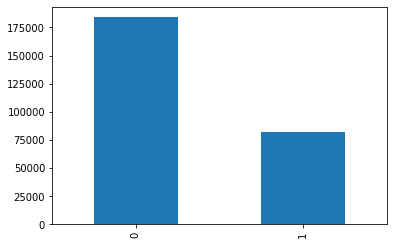

In [6]:
df_up_down_sampled = pd.concat([df_majority, df_minority])
df_up_down_sampled['label'].value_counts().plot(kind='bar')

# Min Max scaler

In [7]:
y = df_up_down_sampled['label']
X = df_up_down_sampled.drop(columns='label')
y_set = y.values
X_set = X.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_set = scaler.fit_transform(X_set)


In [8]:
# import sklearn.external.joblib as extjoblib
import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [9]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_X, test_X, train_y, test_y = train_test_split(X_set, y_set, test_size = 0.3)


# build model

In [10]:
# Thay đổi shape của tập X
time_steps = 1
input_train_lstm = train_X.reshape( train_X.shape[0], time_steps, train_X.shape[1] )

input_test_lstm = test_X.reshape(   test_X.shape[0], time_steps, test_X.shape[1])


In [11]:
# #Building the LSTM Model
lstm = Sequential()
# unit = hidden state
lstm.add(LSTM(units=64, input_shape=(time_steps, input_train_lstm.shape[2]), activation='relu', return_sequences=True))

lstm.add(LSTM(units=128, activation='relu', return_sequences=True))

lstm.add(LSTM(units=64, activation='relu', return_sequences=False))

# lop dau vao hinh tron
lstm.add(Dense(1)) 

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
lstm.summary()
file_name = "/home/onos/Downloads/flask_SDN/lstmlocal.hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='accuracy', save_best_only=True, mode='auto', period=1, verbose=1)
# early = EarlyStopping(monitor='accuracy')
epoch=100

from time import time
start = time()

history = lstm.fit(input_train_lstm,
                   train_y,
                   epochs=epoch,
                   verbose=1,
                   callbacks=[checkpoint])
                   
print('Total training time: ', time()-start)

2022-08-03 15:06:45.841619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-03 15:06:45.841640: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-03 15:06:45.841654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-08-03 15:06:45.841905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18688     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 166,977
Trainable params: 166,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


In [ ]:
from keras.utils import plot_model
plot_model(lstm)